In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

2.8.0+cu126
2.8.0+cu126
cuda


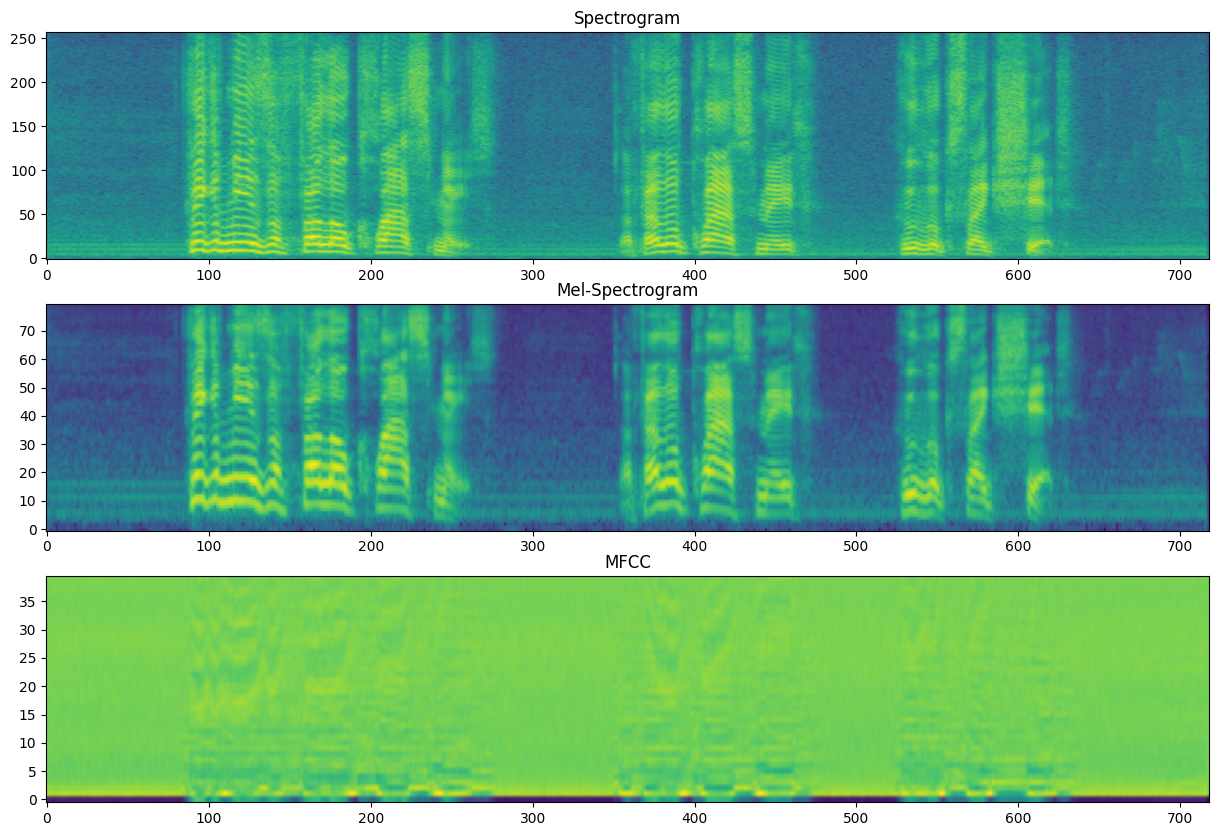

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')
<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>
Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')
THINK|OF|ME|AS|A|FELLOW|CLASSMATE|A|FELLOW|CLASSMATE|WHO|LOOKS|LIKE|SHIT|


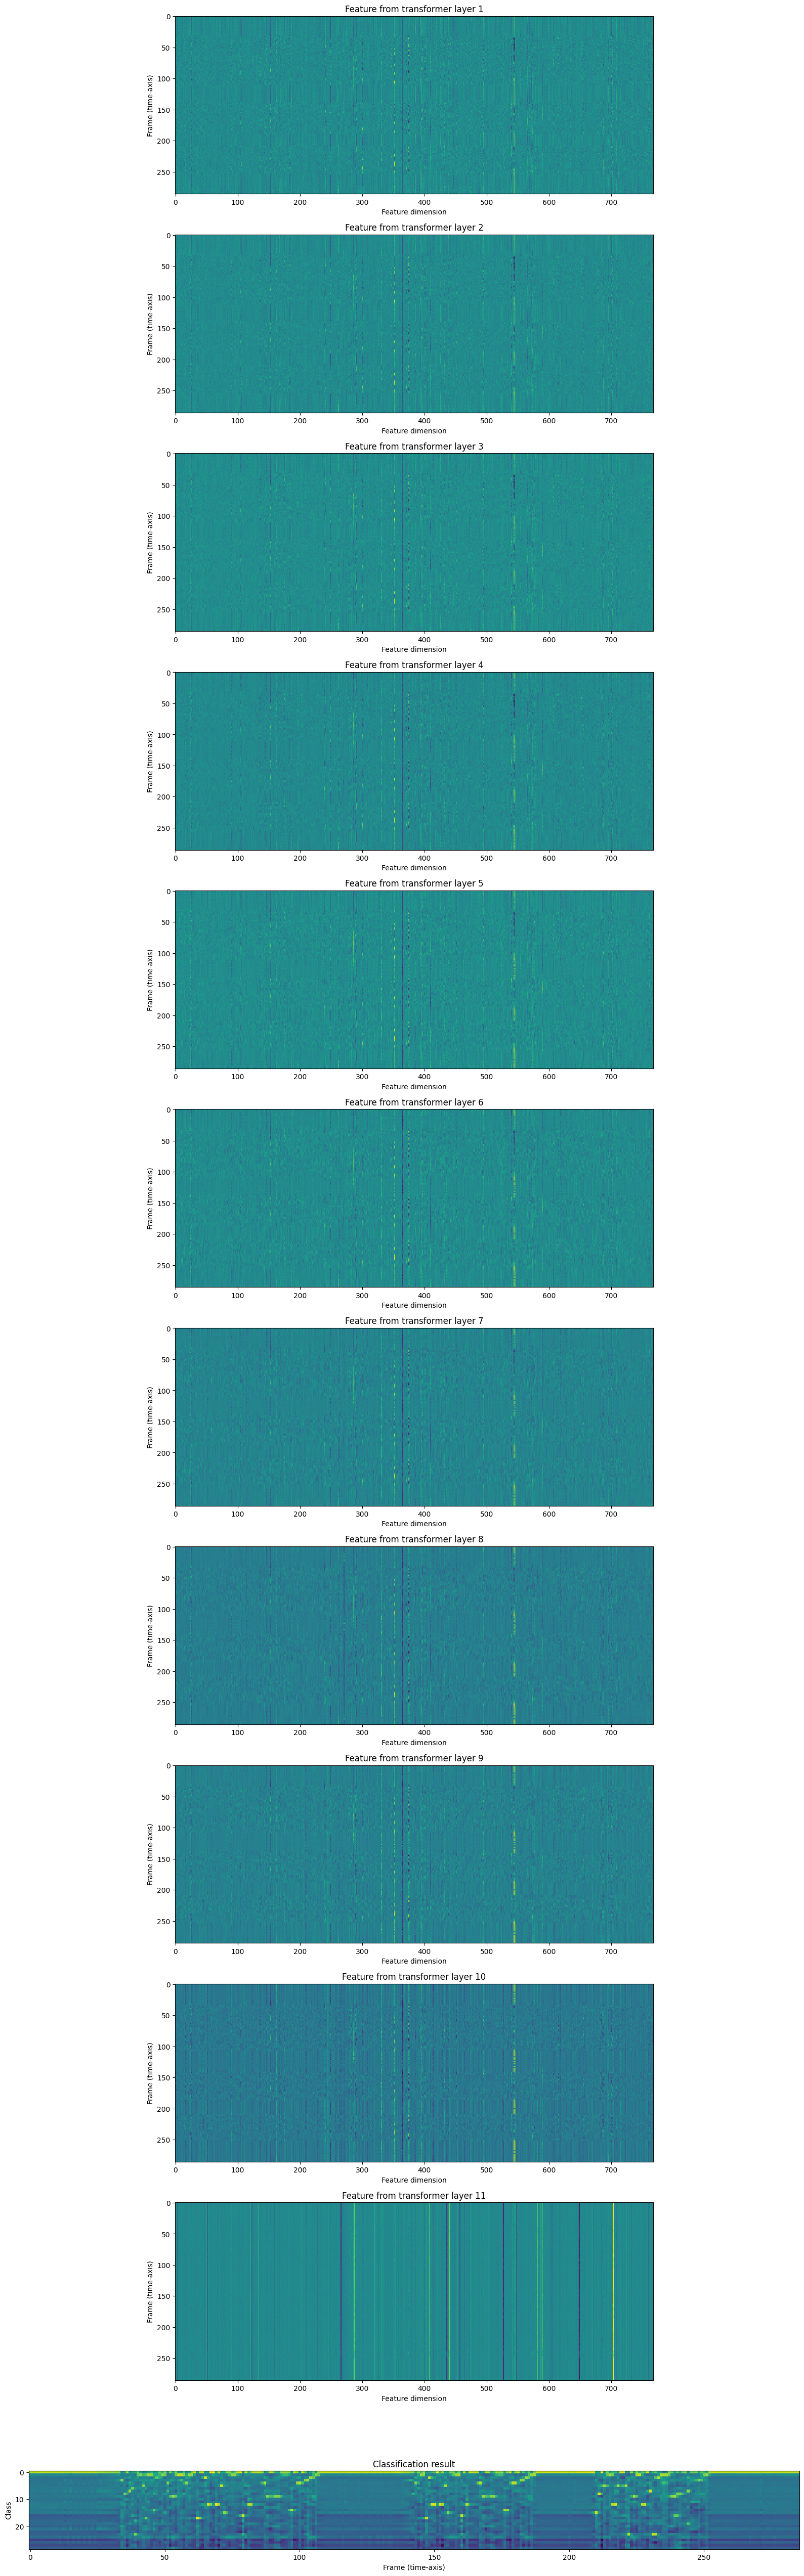

In [8]:
import torch
import torchaudio
import IPython
import matplotlib.pyplot as plt
import torchaudio.transforms as T

SPEECH_FILE = "audio_dataset/English.wav"

spec_transform = T.Spectrogram(n_fft=512, hop_length=128)
mel_transform = T.MelSpectrogram(sample_rate=16000, n_fft=512, hop_length=128, n_mels=80)
mfcc_transform = T.MFCC(sample_rate=16000, n_mfcc=40, melkwargs={"n_fft":512, "hop_length":128, "n_mels":80})

waveform, sr = torchaudio.load(SPEECH_FILE)
if sr != 16000:
    waveform = torchaudio.functional.resample(waveform, sr, 16000)
spec = spec_transform(waveform)        # (channel, freq_bins, time_steps)
mel = mel_transform(waveform)
mfcc = mfcc_transform(waveform)

fig, axs = plt.subplots(3, 1, figsize=(15, 10))
axs[0].imshow(spec[0].log2().detach().numpy(), aspect="auto", origin="lower")
axs[0].set_title("Spectrogram")
axs[1].imshow(mel[0].log2().detach().numpy(), aspect="auto", origin="lower")
axs[1].set_title("Mel-Spectrogram")
axs[2].imshow(mfcc[0].detach().numpy(), aspect="auto", origin="lower")
axs[2].set_title("MFCC")
plt.show()


bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)
print("Labels:", bundle.get_labels())

model = bundle.get_model().to(device)
print(model.__class__)


waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

with torch.inference_mode():
    emission, _ = model(waveform)
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

print(transcript)
IPython.display.Audio(SPEECH_FILE)